In [1]:
import numpy as np, pandas as pd, celerite, emcee as mc, corner
from celerite import terms
from glob import glob
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from WISE_tools import *

%matplotlib inline

In [2]:
unique_names = parse_source_names('test_data/')

J000108.82+585847.4


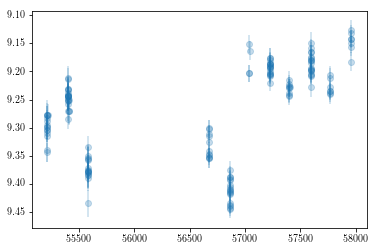

In [3]:
#Try accessing and concatenating lightcurves
for name in unique_names[:1]:
    print(name)
    
    df = get_lightcurve(name, 'test_data/')
    
    plt.errorbar(df['mjd'], df['w1mpro'], yerr=df['w1sigmpro'],
                 marker='o', linestyle='none', alpha=0.25)
plt.gca().invert_yaxis()

In [4]:
mjd,W1,W1err = df['mjd'].values, df['w1mpro'].values, df['w1sigmpro'].values

### We're going to try the following: obtaining the best-fit DRW hyperparameters for the intravisit stuff!

In [5]:
"""Now for all of these modelling steps, we'll need to define cost functions
and gradients. We'll use the negative (gradient) of the log likelihood calculated
by celerite's gp objects. Thankfully these are independed of the individual gp,
so we can define them once"""

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

### Step 0: Take mean per-visit data

In [33]:
def mean_per_visit(time,mag,err,dt_tol=100):
    """
    Assume some delta time over which something is considered a separate visit.
    """
    visits = []
    visit = np.array([[time[0],mag[0],err[0]]])
    for i in range(1,len(time)):
        dif = time[i] - time[i-1]
        if dif <= dt_tol:
            visit = np.append(visit,[[time[i],mag[i],err[i]]],axis=0)
        else:
            visits.append(visit)
            visit = np.array([[time[i],mag[i],err[i]]])
    visits.append(visit)
    visits = np.array(visits)
    mean_times = []
    mean_mags = []
    mean_errs = []
    for visit in visits:
        mean_times.append(np.mean(visit[:,0]))
        mean_mags.append(np.mean(visit[:,1]))
        mean_errs.append(np.sqrt(np.sum(np.power(visit[:,2],2.0)))/len(visit))
    return np.array(mean_times),np.array(mean_mags),np.array(mean_errs)

J000108.82+585847.4


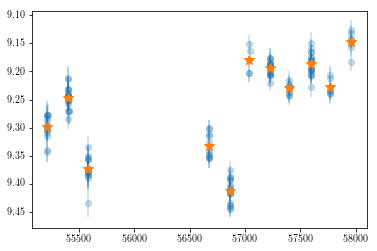

In [34]:
for name in unique_names[:1]:
    print(name)
    
    df = get_lightcurve(name, 'test_data/')
    
    plt.errorbar(df['mjd'], df['w1mpro'], yerr=df['w1sigmpro'],
                 marker='o', linestyle='none', alpha=0.25)
    mt,mw,me = mean_per_visit(mjd,W1,W1err)
    plt.errorbar(mt, mw, yerr=me,
                 marker='*', markersize=10, linestyle='none')
plt.gca().invert_yaxis()

### Step 1: A DRW kernel

### $\kappa_{DRW}(\Delta t) = \sigma^2e^{-\Delta t/\tau}$

In [105]:
#In celerite-land, this looks like a RealTerm (k = ae^-ct), where a = sigma^2, and c = 1/tau
class DRWTerm(terms.RealTerm):
    parameter_names = ("log_sigma", "log_tau")

    def get_real_coefficients(self, params):
        log_sigma, log_tau = params
        sigma = np.exp(log_sigma)
        tau = np.exp(log_tau)
        return (
            sigma**2.0 , 1/tau,
        )
    
#We should probably have smarter bounds on the parameters defined by the data...
DRWbounds = dict(log_sigma=(np.log(np.min(me)), np.log(10.0*np.ptp(mw))), 
                 log_tau=(np.log(0.25*np.min(np.diff(mt))), np.log(2.0*np.ptp(mt))))

#initial parameter guesses: 1 mag for sigma, 500 days for tau?
DRW_kern = DRWTerm(log_sigma=np.log(1), log_tau=np.log(0.5*np.ptp(mt)),bounds=DRWbounds)

#And for now, we're just doing W1. Maybe we should switch into george-land to 
#simultaneously model W1, W2, and W1-W2 at the same time.
DRW_gp = celerite.GP(DRW_kern, mean=np.mean(mw), fit_mean = True)

#Compute the initial covariance matrix for this GP given observed measurement errors
DRW_gp.compute(mt, me)

#How good are we doing?
print("Initial DRW log-likelihood: {0}".format(DRW_gp.log_likelihood(mw)))

Initial DRW log-likelihood: -3.6401109309108186


In [106]:
#Fit for the maximum likelihood parameters, subtract off the mean models, correct observed
#errors for error envelope of DRW
initial_params = DRW_gp.get_parameter_vector()
bounds = DRW_gp.get_parameter_bounds()

#The solver needs autograd.numpy for reasons?
import autograd.numpy as np
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(mw, DRW_gp))
import numpy as np

#How'd we do?
DRW_gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
logs,logt,mean = soln.x

Final log-likelihood: 12.026866021603823


In [107]:
# Make the maximum likelihood prediction
t = np.linspace(np.min(mt), np.max(mt), 500)
DRW_mu, DRW_var = DRW_gp.predict(mw, t, return_var=True)
DRW_std = np.sqrt(DRW_var)

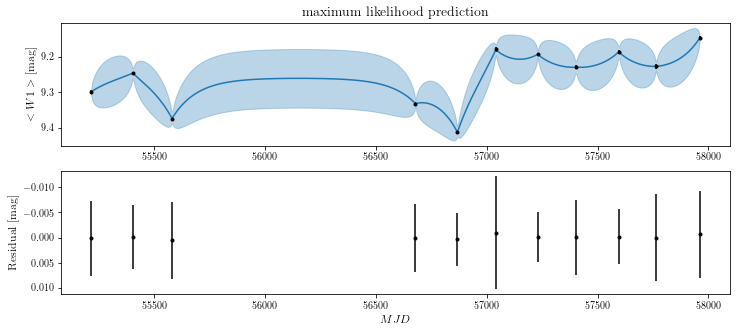

In [108]:
# Plot the data, and the residuals
color = "C0"
fig,ax = plt.subplots(2, figsize = (12,5))
ax[0].errorbar(mt, mw, yerr=me, fmt=".k", capsize=0)
ax[0].plot(t, DRW_mu, color=color)
ax[0].fill_between(t, DRW_mu+DRW_std, DRW_mu-DRW_std, color=color, alpha=0.3, edgecolor="none")
ax[0].set_ylabel(r"$<W1>$ [mag]")
ax[0].invert_yaxis()

mod,mod_var = DRW_gp.predict(mw, mt, return_var = True)
resid_W1 = mw - mod
resid_W1err = np.sqrt(me**2.0 + mod_var)
ax[1].errorbar(mt, resid_W1, yerr=resid_W1err, fmt=".k", capsize=0)
ax[1].set_ylabel(r"Residual [mag]")
ax[1].invert_yaxis()
ax[1].set_xlabel(r"$MJD$")
ax[0].set_title("maximum likelihood prediction");

### Step 2: Explore Possible Realizations with ${\rm {\tt emcee}}$

In [109]:
#Now let's explore possible realizations with emcee.
#Need a log probability
def log_probability(params):
    DRW_gp.set_parameter_vector(params)
    lp = DRW_gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return DRW_gp.log_likelihood(mw) + lp

In [110]:
#Take the maximum likelihood as the initial guess
initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = mc.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in for 500 steps...")
#A tiny little ball around that solution
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running for real for 3000 steps...")
sampler.reset()
np.random.seed(42)
sampler.run_mcmc(p0, 3000);

Running burn-in for 500 steps...
Running for real for 3000 steps...


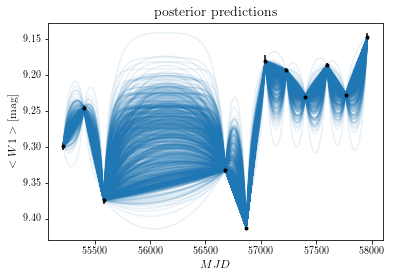

In [116]:
#Let's take 100 samples and see how it looks

# Plot the data.
plt.errorbar(mt, mw, yerr=me, fmt=".k", capsize=0)

# Plot 100 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=1000)]:
    DRW_gp.set_parameter_vector(s)
    mu = DRW_gp.predict(mw, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.1)

plt.ylabel(r"$<W1>$ [mag]")
plt.xlabel(r"$MJD$")
plt.gca().invert_yaxis()
plt.title("posterior predictions");
plt.savefig('rotation_posterior_draws.png')

0.12624455482934427 322.8525869366693


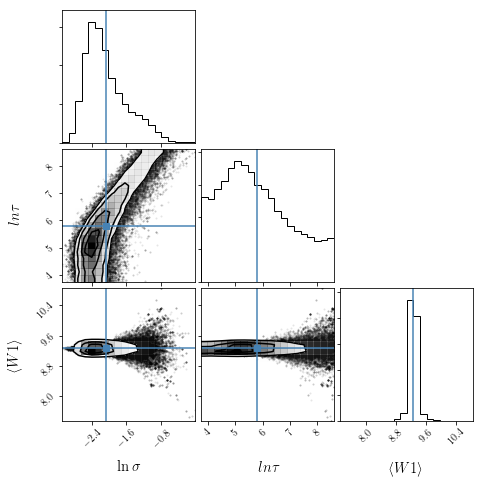

In [114]:
log_sigma_true = np.mean(samples[:,0])
log_tau_true = np.mean(samples[:,1])
mean_true = np.mean(samples[:,2])

print(np.exp(log_sigma_true),np.exp(log_tau_true))

fig = corner.corner(samples, truths=[log_sigma_true,log_tau_true,mean_true],
              labels=[r"$\ln \sigma$", r"$ln\tau$", r"$\langle W1 \rangle$"],
              label_kwargs = {'fontsize':15});
fig.set_size_inches(7,7)

In [51]:
DRW_gp.get_parameter_dict()

OrderedDict([('kernel:log_sigma', -2.3150255593823177),
             ('kernel:log_tau', -892604314541.141),
             ('mean:value', 9.328855333478016)])

### Step 2: Model the residuals with both a stellar-rotation/QPO kernel and a version of the Matern-3/2 kernel implemented in celerite.

### $\kappa_{QPO}(\Delta t) = \frac{a}{2 + b}e^{-\Delta t/\tau}\bigg[cos\bigg(\frac{2\pi\Delta t}{P}\bigg) + (1+b)\bigg]$

### $\kappa_{M-3/2}(\Delta t) = \sigma^2\bigg[\bigg(1+1/\epsilon\bigg)e^{-(1-\epsilon)\sqrt{3}\Delta t/\rho}\bigg(1-1/\epsilon\bigg)e^{-(1+\epsilon)\sqrt{3}\Delta t/\rho}\bigg]$

In [39]:
class QPOTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_tau", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_tau, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b), 1.0/np.exp(log_tau),
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_tau, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) / (2.0 + b), 0.0,
            1.0/np.exp(log_tau), 2*np.pi*np.exp(-log_P),
        )
    
QPObounds = dict(log_a=(None, None), log_b=(None, None), log_tau=(None, None), log_P=(None, None))
Maternbounds = dict(log_sigma=(None, None), log_rho=(None, None), eps=(None, None))

#initial parameter guesses: 0.05 mag for amplitude, 10 days for timescales?
QPO_kern = QPOTerm(log_a=np.log(0.05), log_b=np.log(1), log_tau=np.log(10), log_P=np.log(10))
Matern_kern = terms.Matern32Term(log_sigma=np.log(0.05), log_rho=np.log(10))

#GP objects, remembering this is for the residual values
QPO_gp = celerite.GP(QPO_kern, mean=np.mean(resid_W1), fit_mean = True)
Matern_gp = celerite.GP(Matern_kern, mean=np.mean(resid_W1), fit_mean = True)

#Compute the initial covariance matrix for this GP given residual errors
QPO_gp.compute(mjd, resid_W1err)
Matern_gp.compute(mjd, resid_W1err)

#How good are we doing?
print("Initial QPO log-likelihood: {0}".format(QPO_gp.log_likelihood(W1)))
print("Initial Matern log-likelihood: {0}".format(Matern_gp.log_likelihood(W1)))

Initial QPO log-likelihood: -11917.654657273106
Initial Matern log-likelihood: -193548.70254237813


In [40]:
#Fit for the maximum likelihood parameters of both

QPO_initial_params = QPO_gp.get_parameter_vector()
QPO_bounds = QPO_gp.get_parameter_bounds()

Matern_initial_params = Matern_gp.get_parameter_vector()
Matern_bounds = Matern_gp.get_parameter_bounds()

#The solver needs autograd.numpy for reasons?
import autograd.numpy as np
QPO_soln = minimize(neg_log_like, QPO_initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=QPO_bounds, args=(resid_W1, QPO_gp))
Matern_soln = minimize(neg_log_like, Matern_initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=Matern_bounds, args=(resid_W1, Matern_gp))
import numpy as np

#How'd we do?
QPO_gp.set_parameter_vector(QPO_soln.x)
Matern_gp.set_parameter_vector(Matern_soln.x)
print("Final QPO log-likelihood: {0}".format(-QPO_soln.fun))
print("Final Matern log-likelihood: {0}".format(-Matern_soln.fun))

Final QPO log-likelihood: 399.74055980154185
Final Matern log-likelihood: 399.7405614168774


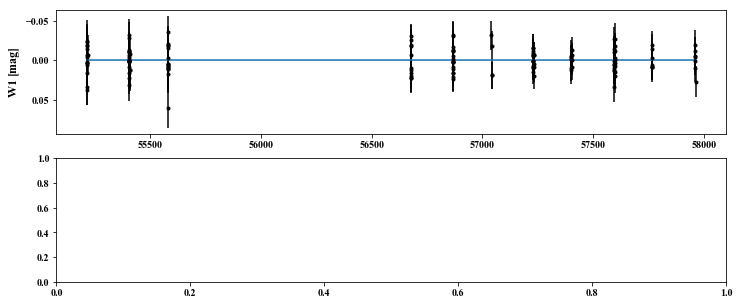

In [41]:
# Plot the data, and the residuals
QPO_mu, QPO_var = QPO_gp.predict(resid_W1, t, return_var=True)
QPO_std = np.sqrt(QPO_var)

color = "C0"
fig,ax = plt.subplots(2, figsize = (12,5))
ax[0].errorbar(mjd, resid_W1, yerr=resid_W1err, fmt=".k", capsize=0)
ax[0].plot(t, QPO_mu, color=color)
ax[0].fill_between(t, QPO_mu+QPO_std, QPO_mu-QPO_std, color=color, alpha=0.3, edgecolor="none")
ax[0].set_ylabel(r"$W1$ [mag]")
ax[0].invert_yaxis()

In [42]:
# Zooming in on individual visits:
dt_tol = 100
visits = []
visit = np.array([[mjd[0],resid_W1[0],resid_W1err[0]]])
for i in range(1,len(mjd)):
    dif = mjd[i] - mjd[i-1]
    if dif <= dt_tol:
        visit = np.append(visit,[[mjd[i],resid_W1[i],resid_W1err[i]]],axis=0)
    else:
        visits.append(visit)
        visit = np.array([[mjd[i],resid_W1[i],resid_W1err[i]]])
visits.append(visit)
visits = np.array(visits)

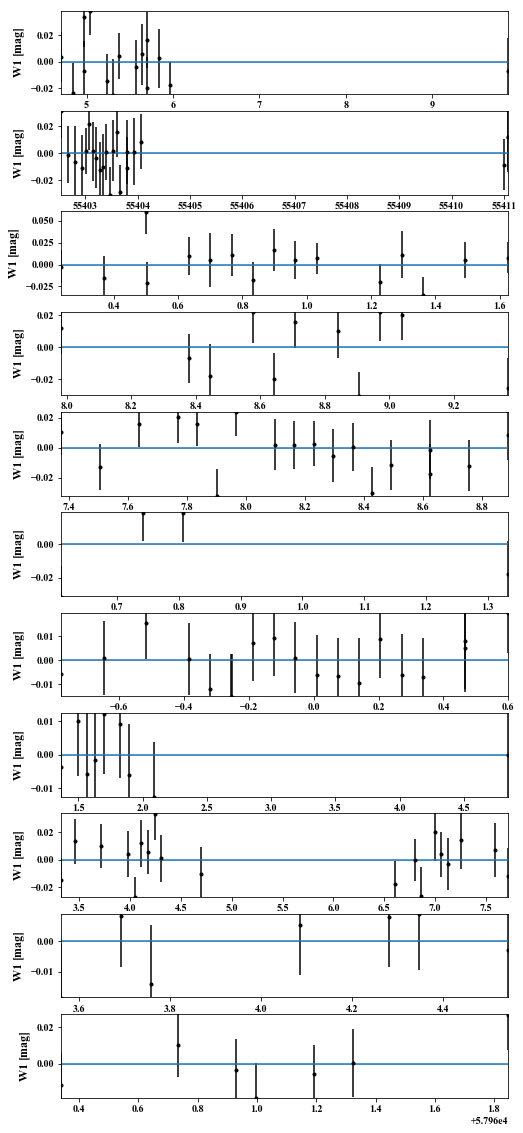

In [43]:
fig,axes = plt.subplots(len(visits), figsize = (8,20))

for ax,visit in zip(axes,visits):
    ms = visit[:,0]
    ws = visit[:,1]
    es = visit[:,2]
    
    ax.errorbar(ms, ws, yerr=es, fmt=".k", capsize=0)
    ax.plot(t, QPO_mu, color=color)
    ax.fill_between(t, QPO_mu+QPO_std, QPO_mu-QPO_std, color=color, alpha=0.3, edgecolor="none")
    ax.set_ylabel(r"$W1$ [mag]")
    ax.invert_yaxis()
    ax.set_xlim(min(ms),max(ms))
    ax.set_ylim(0.99*min(ws),1.01*max(ws))

In [ ]:
#And individual visits:

fig,axes = plt.subplots(len(visits), figsize = (8,20))

for ax,visit in zip(axes,visits):
    ms = visit[:,0]
    ws = visit[:,1]
    es = visit[:,2]
    
    ax.errorbar(ms, ws, yerr=es, fmt=".k", capsize=0)
    ax.set_ylabel(r"$W1$ [mag]")
    ax.invert_yaxis()
    ax.set_xlim(min(ms),max(ms))
    ax.set_ylim(0.99*min(ws),1.01*max(ws))
    
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(W1, t, return_cov=False)
    for ax,visit in zip(axes,visits):
        ax.plot(t, mu, color=color)
        
plt.savefig('rotation_posterior_draws_visits.png')

In [ ]:
log_a_true = np.mean(samples[:,0])
log_b_true = np.mean(samples[:,1])
log_tau_true = np.mean(samples[:,2])
log_P_true = np.mean(samples[:,3])
mean_true = np.mean(samples[:,4])

fig = corner.corner(samples, truths=[log_a_true,log_b_true,log_tau_true,log_P_true,mean_true],
              labels=[r"$\ln a$", r"$\ln b$", r"$ln\tau$", r"$\ln P$", r"$\langle W1 \rangle$"],
              label_kwargs = {'fontsize':15});
fig.set_size_inches(7,7)
plt.savefig('rotation_posterior_corner.png')

In [ ]:
fig,ax = plt.subplots(5, figsize=(12,5))
for walker in sampler.chain:
    ax[0].plot(walker[:,0],c='k',alpha=0.2)
    ax[1].plot(walker[:,1],c='k',alpha=0.2)
    ax[2].plot(walker[:,2],c='k',alpha=0.2)
    ax[3].plot(walker[:,3],c='k',alpha=0.2)
    ax[4].plot(walker[:,4],c='k',alpha=0.2)
ax[0].set_ylabel('log a')
ax[1].set_ylabel('log b')
ax[2].set_ylabel('log tau')
ax[3].set_ylabel('log P')
ax[4].set_ylabel('mean')
plt.savefig('rotation_chains.png')